# Fresnel Rhomb

**Scott Prahl**

*April 2018*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pypolar.jones as jones
import pypolar.mueller as mueller
import pypolar.fresnel as fresnel
from scipy.optimize import brentq

## Description

The Fresnel rhomb uses the phenomenon that total internal reflection introduces a phase shift between the parallel and perpendicular electric fields.  Fresnel noted that the phase shift varies with the angle of incidence, and more specifically, that a phase shift of 45° could be achieved with a single reflection.

Two total internal reflection bounces would cause a 90° phase shift between the fields (quarter-wave) and bouncing four times will create a 180° shift (half-wave)

<img src="http://www.thorlabs.com/images/TabImages/FR600QM_Drawing_780.gif">

[Wikipedia](https://en.wikipedia.org/wiki/Fresnel_rhomb#cite_note-fresnel-1818d-4) has a surprisingly detailed page about the Fresnel Rhomb, and says

>The rhomb usually takes the form of a right parallelepiped — that is, a right parallelogram-based prism. If the incident ray is perpendicular to one of the smaller rectangular faces, the angle of incidence and reflection at the next face is equal to the acute angle of the parallelogram. This angle is chosen so that each reflection introduces a phase difference of 45° between the components polarized parallel and perpendicular to the plane of reflection. 

[LightMachinery](https://lightmachinery.com/optical-design-center/library/users-guides/fresnel-rhomb-designer-users-guide/) succinctly describes the advantages of a Fresnel Rhomb over a  birefringent waveplate:

> A Fresnel rhomb is a type of waveplate that has certain advantages over the more standard waveplates that use a material's birefringence. In a Fresnel rhomb, the induced phase change between $s-$ and $p-$ polarized light depends only on the material's index of refraction and the geometry, and not explicitly on the design wavelength. Fresnel rhombs typically operate over a much larger wavelength range than a typical zero-order birefringence-based waveplate. For some wavelength ranges (for example, 10.6 μm CO$_2$ lasers), there are no convenient birefringent materials for standard waveplates. Since Fresnel rhombs only need transparent non-birefringent materials, they can be used over virtually any wavelength range.

## Induced Phase Change a Function of Rhomb Angle

If the acute angle of the rhombus is $\theta$ then the incident angle $\phi$ (from the normal to the rhombus face) will be $\phi=\pi/2-\theta$.

The Fresnel field reflection will light hitting the inside face of the glass rhombus (with index n) will be described by m=1/n.

For a glass such as BK7, a commonly used optical glass made by Schott, the
refractive index n at a wavelength of 632.8 nm (He–Ne wavelength) is 1.5151.

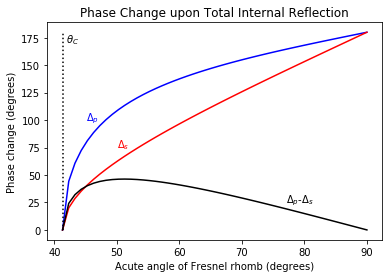

In [2]:
n = 1.5151
m=1/n
radians = np.pi/180          # to convert from degrees to radians
degrees = 180 / np.pi        # to convert from radians to degrees

# only consider total internal reflection ==> angles > critical angle
critical = np.arcsin(m)*degrees
theta = np.linspace(critical,90,50)
th = theta * radians

rp = fresnel.r_par(m,th)
rs = fresnel.r_per(m,th)

plt.plot(theta, np.angle(rp)*degrees, color='blue')
plt.plot(theta, np.angle(rs)*degrees, color='red')
plt.plot(theta, np.angle(rp)*degrees-np.angle(rs)*degrees,'k')

plt.annotate(r'$\Delta_p$', xy=(45,100), color='blue')
plt.annotate(r'$\Delta_s$', xy=(50,75), color='red')
plt.annotate(r'$\Delta_p$-$\Delta_s$', xy=(77,25))

plt.plot([critical,critical],[0,180],':k')
plt.annotate(r' $\theta_C$',  xy=(critical, 180), va='top')
plt.title('Phase Change upon Total Internal Reflection')

plt.xlabel("Acute angle of Fresnel rhomb (degrees)")
plt.ylabel("Phase change (degrees)")

plt.show()

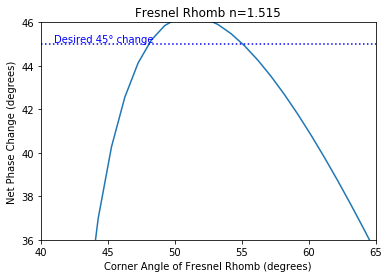

In [3]:
plt.plot(theta, np.degrees(np.angle(rp)-np.angle(rs)))
plt.axhline(45,color='blue',ls=':')
plt.text(41, 45, 'Desired 45° change', color='blue', va='bottom')

plt.xlabel("Corner Angle of Fresnel Rhomb (degrees)")
plt.ylabel("Net Phase Change (degrees)")
plt.title("Fresnel Rhomb n=%.3f"%n)
plt.ylim(36,46)
plt.xlim(40,65)
plt.show()

Solve for the exact angles using the `scipy.optimize.brentq` method.

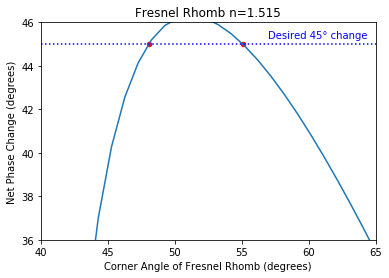

In [4]:
n=1.5151                # refractive index of Fresnel Rhomb

def min_rhomb(theta):
    m = 1/n
    rp = fresnel.r_par(m,theta*np.pi/180)
    rs = fresnel.r_per(m,theta*np.pi/180)
    delta = np.pi/4 - (np.angle(rp)-np.angle(rs))
    return delta

# brentq requires that the zero fall between two points
theta1 = brentq(min_rhomb,46,51)
theta2 = brentq(min_rhomb,51,60)

plt.plot(theta, np.angle(rp)*degrees-np.angle(rs)*degrees)
plt.plot([40,65],[45,45],':b')
plt.scatter([theta1,theta2],[45,45],s=20,color='red')
plt.text(57, 45.2, 'Desired 45° change', color='blue', va='bottom')

plt.xlabel("Corner Angle of Fresnel Rhomb (degrees)")
plt.ylabel("Net Phase Change (degrees)")
plt.title("Fresnel Rhomb n=%.3f"%n)
plt.ylim(36,46)
plt.xlim(40,65)
plt.show()

In [5]:
print('The first  possible Fresnel rhomb corner angle is %.4f°'%theta1)
print('The second possible Fresnel rhomb corner angle is %.4f°'%theta2)

The first  possible Fresnel rhomb corner angle is 48.0440°
The second possible Fresnel rhomb corner angle is 55.0822°


## Validation using Jones calculus

The Fresnel rhomb should convert linearly polarized light at 45° to left circularly polarized light after two bounces

In [6]:
m=1/1.5151
angle = 48.0440*np.pi/180

P = jones.field_linear(45*np.pi/180)
R = jones.op_fresnel_reflection(m, angle)

out = R @ R @ P

print(jones.interpret(out))


Intensity is 1.000
Phase is 270.0°
Left circular polarization


In [7]:
m=1/1.5151
angle = 55.0822*np.pi/180

P = jones.field_linear(45*np.pi/180)
R = jones.op_fresnel_reflection(m, angle)

out = R @ R @ P

print(jones.interpret(out))


Intensity is 1.000
Phase is 270.0°
Left circular polarization


## Validation using Mueller calculus

In [8]:
m=1/1.5151
angle = 48.0440*np.pi/180

R = mueller.op_fresnel_reflection(m, angle)
P = mueller.stokes_linear(45*np.pi/180)

out = R @ R @ P

print('Mueller matrix result')
print(out)
print('Left Circular Polarization is:')
print(mueller.stokes_left_circular())


Mueller matrix result
[ 1.00000000e+00  2.83276945e-16  9.16953788e-07 -1.00000000e+00]
Left Circular Polarization is:
[ 1  0  0 -1]


In [9]:
m=1/1.5151
angle = 55.0822*np.pi/180

R = mueller.op_fresnel_reflection(m, angle)
P = mueller.stokes_linear(45*np.pi/180)

out = R @ R @ P

print('Mueller matrix result')
print(out)
print('Left Circular Polarization is:')
print(mueller.stokes_left_circular())


Mueller matrix result
[ 1.00000000e+00 -3.82856870e-16 -8.04847201e-07 -1.00000000e+00]
Left Circular Polarization is:
[ 1  0  0 -1]
